In [1]:
import os
import sys
sys.path.insert(0, '..')

In [2]:
import time
import cv2
from PIL import Image
import numpy as np
import torch
from diffusers import (
    StableDiffusionXLControlNetUnionPipeline,
    UNet2DConditionModel,
    AutoencoderKL,
    ControlNetUnionModel,
)
from mirror_ai.controlnet.controlnet_union import ControlNetModel_Union
from controlnet_aux import MidasDetector, OpenposeDetector
from huggingface_hub import hf_hub_download
from diffusers.utils.torch_utils import randn_tensor
import torch_tensorrt
from safetensors.torch import load_file
from torchao.quantization import swap_conv2d_1x1_to_linear

from controlnet_aux import LineartAnimeDetector
from diffusers import StableDiffusionXLControlNetUnionPipeline, ControlNetUnionModel, AutoencoderKL
from diffusers.utils import load_image
import torch

from dotenv import load_dotenv

/BigStorage/MerlinsPlace/mmm/merlins-mirror/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Unable to import quantization op. Please install modelopt library (https://github.com/NVIDIA/TensorRT-Model-Optimizer?tab=readme-ov-file#installation) to add support for compiling quantized models
TensorRT-LLM is not installed. Please install TensorRT-LLM or set TRTLLM_PLUGINS_PATH to the directory containing libnvinfer_plugin_tensorrt_llm.so to use converters for torch.distributed ops


[04/07/2025-15:18:54] [TRT] [W] Functionality provided through tensorrt.plugin module is experimental.


In [3]:
load_dotenv('../.env')
os.getenv('HF_HOME')

'/BigStorage/MerlinsPlace/mmm/merlins-mirror/local_models/'

In [4]:
from mirror_ai import config

In [5]:
depth_model = MidasDetector.from_pretrained("lllyasviel/Annotators").to(config.DEVICE)
pose_model  = OpenposeDetector.from_pretrained("lllyasviel/ControlNet").to(config.DEVICE)

In [6]:
%%capture
# Instantiate UNet from config, then load the specific Lightning weights
unet_config = UNet2DConditionModel.load_config(config.SDXL_BASE_MODEL_ID, subfolder="unet")
unet = UNet2DConditionModel.from_config(unet_config).to(config.DEVICE, dtype=config.DTYPE)
lightning_ckpt_file = config.LIGHTNING_CKPT_TEMPLATE.format(n_steps=config.N_STEPS)
unet.load_state_dict(
    load_file(
        hf_hub_download(config.SDXL_LIGHTNING_REPO_ID, lightning_ckpt_file),
        device=config.DEVICE
    )
)
unet.to(dtype=config.DTYPE)

In [7]:

prompt = "A cat"
# download an image
image = load_image(
"https://huggingface.co/datasets/hf-internal-testing/diffusers-images/resolve/main/kandinsky/cat.png"
 ).resize((1024, 1024))
# initialize the models and pipeline
controlnet = ControlNetUnionModel.from_pretrained(
     "xinsir/controlnet-union-sdxl-1.0", torch_dtype=torch.float16
 )


In [8]:
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)

In [9]:
pipe = StableDiffusionXLControlNetUnionPipeline.from_pretrained(
     "stabilityai/stable-diffusion-xl-base-1.0",
     unet=unet,
     controlnet=controlnet,
     vae=vae,
     torch_dtype=torch.float16,
     variant="fp16",
 )

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 31.71it/s]


In [10]:
# Configure the Scheduler (CRITICAL for SDXL Lightning)
scheduler_name = config.SCHEDULER_NAME
print(f"Configuring Scheduler ({scheduler_name}, spacing='{config.SCHEDULER_TIMESTEP_SPACING}')...")
pipe.scheduler = config.SCHEDULERS[scheduler_name].from_config(
    pipe.scheduler.config,
    timestep_spacing=config.SCHEDULER_TIMESTEP_SPACING
)

Configuring Scheduler (K_EULER, spacing='trailing')...


In [11]:

pipe.enable_model_cpu_offload()


In [12]:

# prepare image
# processor = LineartAnimeDetector.from_pretrained("lllyasviel/Annotators")
processor = depth_model
depth_img = depth_model(image, output_type="pil")
pose_img = pose_model(image, hand_and_face=False, output_type='pil')
controlnet_img = [pose_img, depth_img]

In [13]:
controlnet_img[0].size,controlnet_img[1].size

((512, 512), (512, 512))

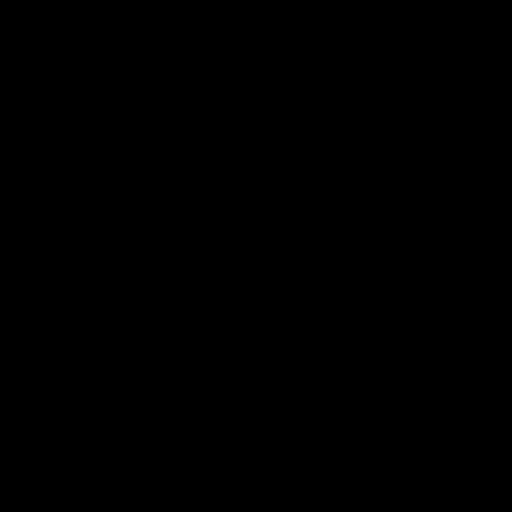

In [14]:
controlnet_img[0]

In [15]:

# generate image
image = pipe(
    prompt,
    control_image=controlnet_img,
    control_mode=[0, 1],
    num_inference_steps=4,
    height=1024,
    width=1024
).images[0]

LATENTS SHAPE: torch.Size([1, 4, 128, 128])


100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


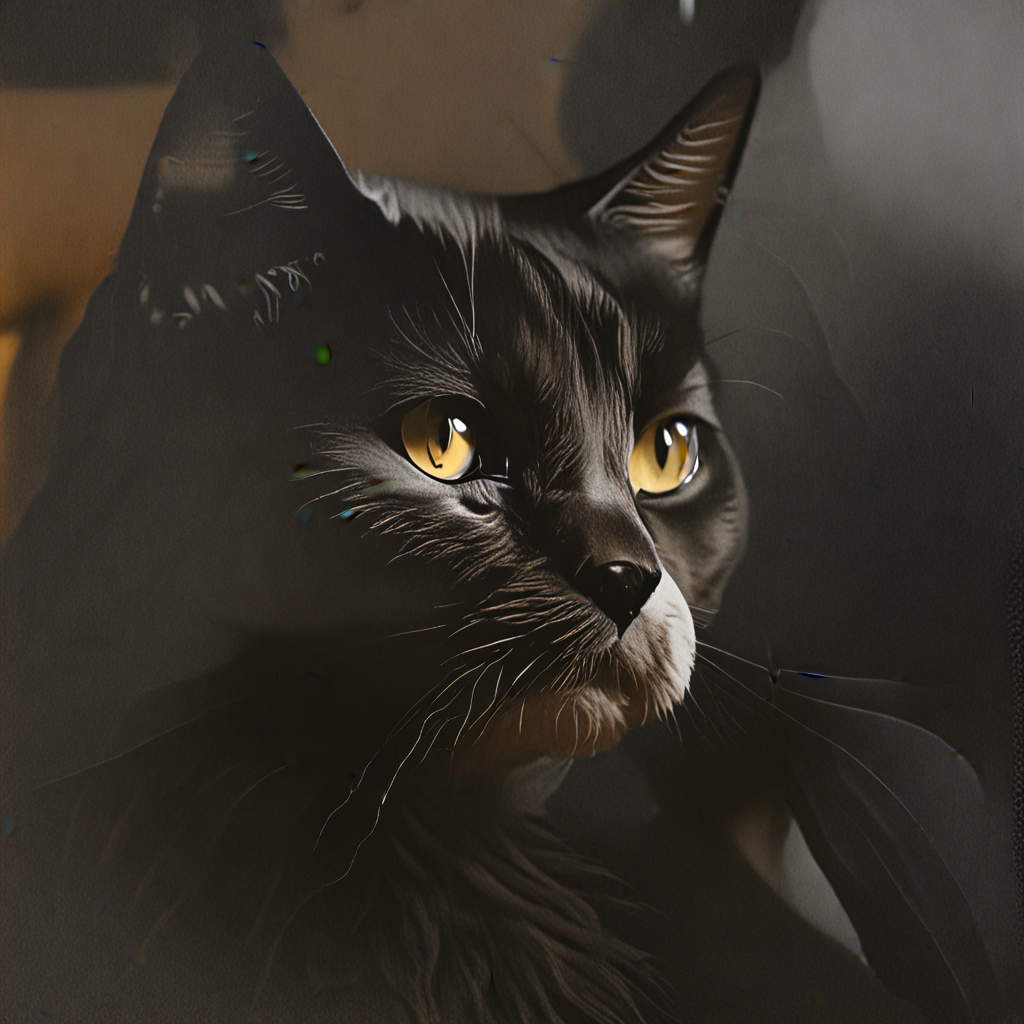

In [16]:
image